In [1]:
# import modules
import uproot, sys, time, random, argparse, copy, csv, json, math, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *


# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [ ]:
base_path = "/data/jlai/iris-hep/"
root_file = os.path.join(base_path, "output10", "tracksummary_ckf.root")

plot_dir = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots"
os.makedirs(plot_dir, exist_ok=True)

pT_values = [10] 
i = 0
eta = 0
B = 2.0            # Tesla
m_mu = 0.106       # GeV

detector_txt = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_best.txt"

# ----- Read ACTS tree -----
file = uproot.open(root_file)
tree = file["tracksummary"]

arr = tree.arrays([
    "t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
    "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
    "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
    "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
    "t_p", "eQOP_fit", "res_eQOP_fit", "pull_eQOP_fit",
    "t_charge"
], library="ak")

pT_truth = arr["t_p"] * np.sin(arr["t_theta"])

pT_reco = np.abs(1.0 / arr["eQOP_fit"]) * np.sin(arr["eTHETA_fit"])

labels = {
    'sigma(d)':      ak.flatten(arr['res_eLOC0_fit']) * 1e3,  # mm -> µm
    'sigma(z)':      ak.flatten(arr['res_eLOC1_fit']) * 1e3,  # mm -> µm
    'sigma(phi)':    ak.flatten(arr['res_ePHI_fit']),         # rad
    'sigma(theta)':  ak.flatten(arr['res_eTHETA_fit']),       # rad
    'sigma(pt)/pt':  ak.flatten((pT_reco - pT_truth) / pT_truth)  # fractional
}

# ----- Fit Gaussians, compute SE(σ), and plot histograms -----
fit_results = {}  # key -> {"mu":..., "sigma":..., "n":..., "se":...}

plt.figure(figsize=(30, 13))
for j, (key, data) in enumerate(labels.items()):
    data = ak.to_numpy(data)
    # Remove non-finite values
    data = data[np.isfinite(data)]
    if data.size < 3:
        continue

    # Fit (MLE)
    mu, sigma_fit = norm.fit(data)
    s = np.std(data, ddof=1)
    se_sigma = s / np.sqrt(2 * (data.size - 1))

    fit_results[key] = {"mu": mu, "sigma": sigma_fit, "n": data.size, "se": se_sigma}

    # Plot residual histogram + Gaussian fit
    ax = plt.subplot(2, 3, j + 1)
    counts, bins, _ = plt.hist(
        data, bins=100, histtype='step', linewidth=2, density=True,
        alpha=0.6, color='gray', label='Residuals'
    )
    x = np.linspace(bins[0], bins[-1], 1000)
    ax.plot(x, norm.pdf(x, mu, sigma_fit), 'r--',
            label=(f'pT={pT_values[i]} GeV\nμ={mu:.2e}\nσ={sigma_fit:.2e}\nN={data.size}'))
    ax.set_title(key)
    ax.set_xlabel(key)
    ax.set_ylabel("Frequency (normalized)")
    ax.grid(True)
    ax.legend()

hist_path = os.path.join(plot_dir, f"fitted_gaussian_pT{pT_values[i]}.png")
plt.tight_layout()
plt.show()
# plt.savefig(hist_path, dpi=150)
# plt.close()
print(f"[saved] {hist_path}")

# ----- Tracking Error Calculator -----
# Expecting: inputfromfile(txt_path, verbose_flag) -> detector object with .errorcalculation(p, B, eta, m)
try:
    # If the function is already in your namespace, this will just work.
    detector = inputfromfile(detector_txt, 0)
except NameError as e:
    raise RuntimeError(
        "inputfromfile(...) is not defined. Import it from your calculator module, e.g.\n"
        "from trackingerror import inputfromfile"
    ) from e

p = float(pT_values[i])  # here we use p ≈ pT at η~0
calc_result = detector.errorcalculation(p, B, eta, m_mu)
# calc_result is expected to be a dict with keys:
# ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

# ----- Comparison plot with error bars for ACTS -----
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(20, 10))
for idx, var_label in enumerate(var_labels):
    ax = plt.subplot(2, 3, idx + 1)

    # Calculator value
    y_calc = calc_result[var_label]

    # ACTS fitted σ and its SE
    if var_label not in fit_results:
        continue
    res = fit_results[var_label]
    y_acts = res["sigma"]
    yerr_acts = res["se"]

    # Plot single-point comparison at x = pT
    pT = pT_values[i]
    ax.scatter(pT, y_calc, marker='o', s=90, label=f"Calculator: {y_calc:.4g}")
    ax.errorbar([pT], [y_acts], yerr=[yerr_acts], fmt='x', ms=8, capsize=4, lw=1.5, color='orange',
                label=f"ACTS: {y_acts:.4g} ± {yerr_acts:.1g}")

    ax.set_xlabel(r"$p_T$ [GeV]")
    ax.set_ylabel(var_label)
    ax.set_title(f"{var_label} @ $p_T$ = {pT} GeV, η = {eta}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
cmp_path = os.path.join(plot_dir, f"calc_vs_acts_pT{pT_values[i]}.png")
plt.show()
# plt.savefig(cmp_path, dpi=150)
# plt.close()
print(f"[saved] {cmp_path}")


In [14]:
# path = '/data/jlai/iris-hep/OutputPT_pixel_only/'
# path = '/data/jlai/iris-hep/OutputPT_shortstrip_only/' # no interaction
path = '/data/jlai/iris-hep/OutputPT/'

var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

# pT_values = np.concatenate((np.linspace(1, 15, 15), np.linspace(20, 100, 9)))
pT_values = np.arange(10, 100, 10)
for pT_value in pT_values:
    pT_value = int(pT_value)
    print(f'Saving ACTS track resol with pT = {pT_value} GeV')
    file = uproot.open(path + f'output_pt_{pT_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten( (pT_reco - pT_truth) ) / ak.flatten(pT_reco) 
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)

        y_acts[key].append(sigma)
        # y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)
        y_acts_err[key].append(sigma / np.sqrt(2*max(N-1,1)) if N > 1 else 0.0)

Saving ACTS track resol with pT = 10 GeV
Saving ACTS track resol with pT = 20 GeV
Saving ACTS track resol with pT = 30 GeV
Saving ACTS track resol with pT = 40 GeV
Saving ACTS track resol with pT = 50 GeV
Saving ACTS track resol with pT = 60 GeV
Saving ACTS track resol with pT = 70 GeV
Saving ACTS track resol with pT = 80 GeV
Saving ACTS track resol with pT = 90 GeV


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

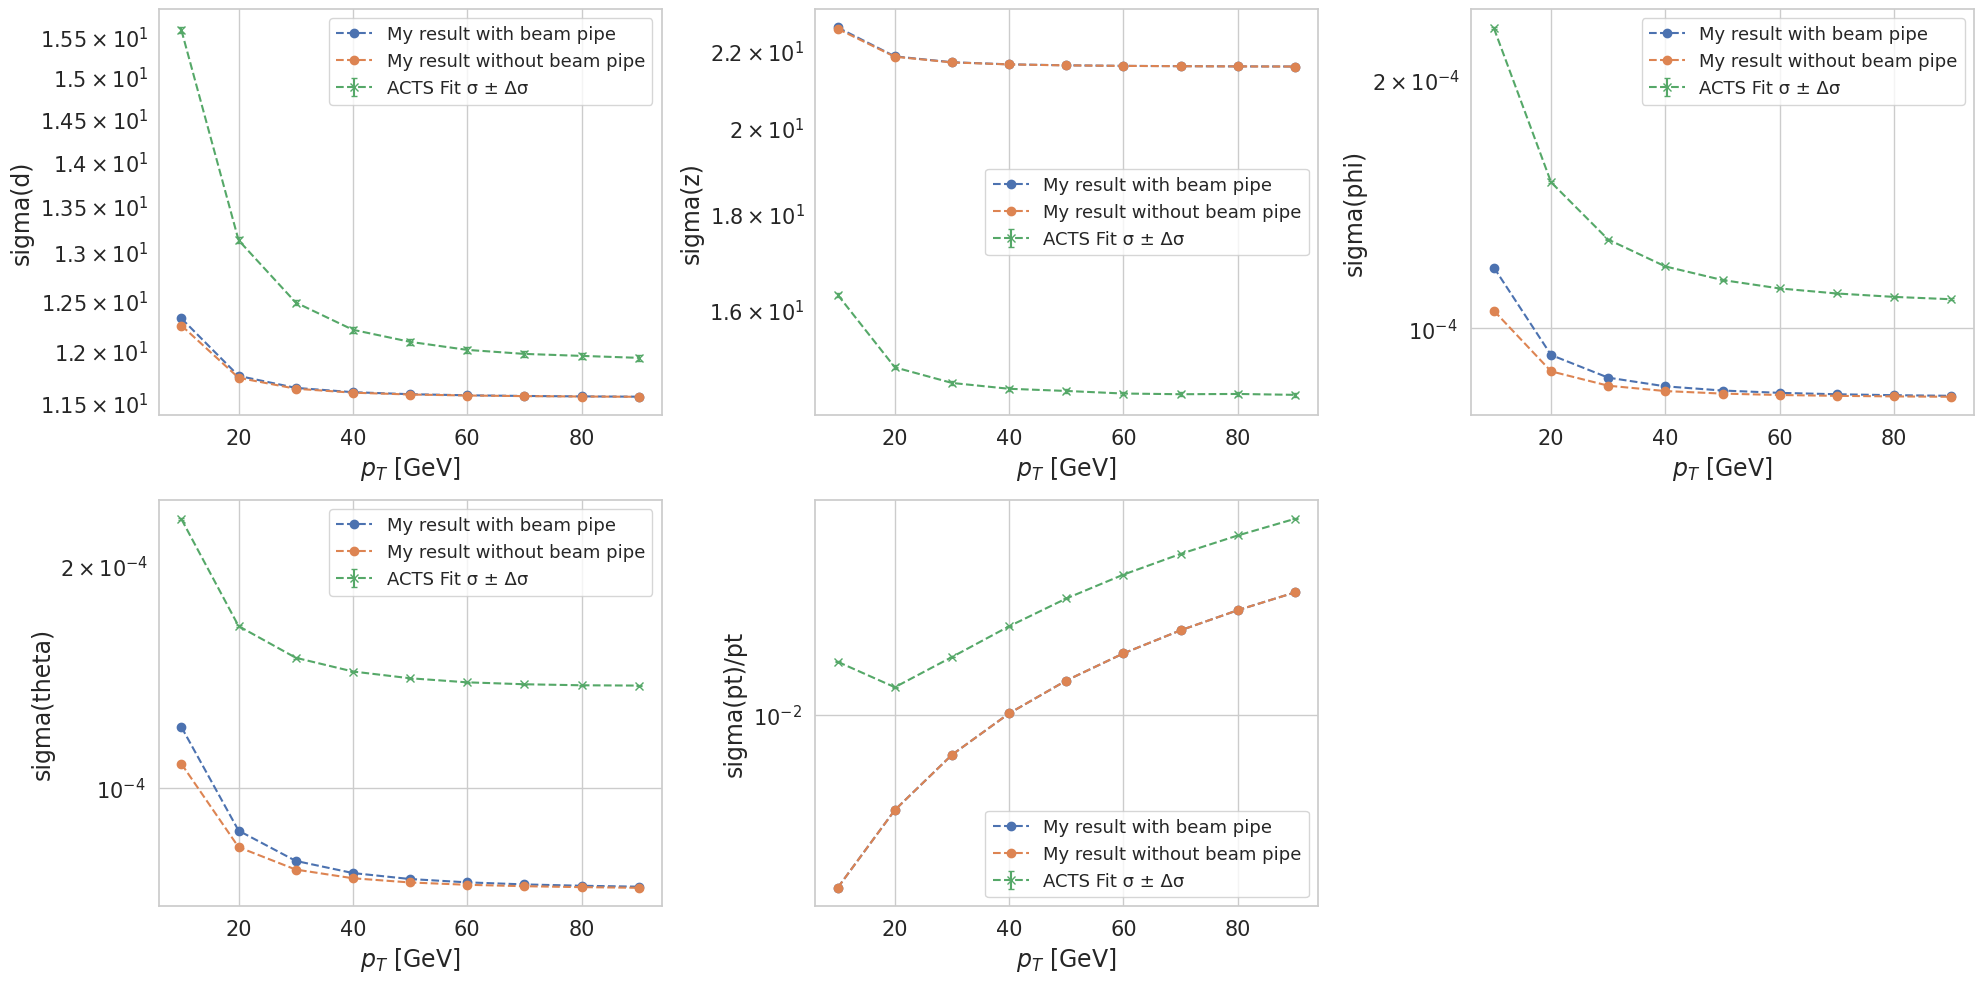

In [15]:
# < -- Tracking Error Calculator -- >
def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2.6, 0.106
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc = cal(path+'ODD.txt')
y_calc2 = cal(path+'ODD_test2.txt')
# y_calc2 = cal(path+'myODD2.txt')
# y_calc3 = cal(path+'myODD_pixel_only_best.txt')
y_calc3 = cal(path+'ODD_test1.txt')

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)
    # plt.plot(pT_values, y_calc[var_label], 'o--', label=f"Default Calculator in zenodo")
    plt.plot(pT_values, y_calc2[var_label], 'o--', label=f"My result with beam pipe")
    plt.plot(pT_values, np.array(y_calc3[var_label]), 'o--', label=f"My result without beam pipe")
    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
VAR_LABELS = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)']#, 'sigma(pt)/pt']

# ========= Pixel-only base config =========
beam_pipe = (0.00227, 9999.0, 9999.0, 0.024)  # width, resxy, resz, pos (m)
# pixel_positions_base = np.array([0.034, 0.070, 0.116, 0.172], dtype=float)
pixel_positions_base = np.array([0.032779, 0.069890, 0.111088, 0.166687])

pixel_base_width = 0.01225
# pixel_base_width = 0
widths_base = np.array([pixel_base_width]*4, dtype=float)  # per-layer widths
# resxy_base = 0.015e-3
# resz_base  = 0.015e-3

resxy_base, resz_base = 1.341284e-05, 1.341284e-05
pos_off_base = np.zeros(4, dtype=float)  # per-layer position offsets (m)

# ========= Bounds & steps =========
WIDTH_MIN, WIDTH_MAX = 0, 0.05
RES_MIN, RES_MAX, POS_MIN, POS_MAX = resxy_base, resz_base, 0, 0
# RES_MIN,   RES_MAX   = 5e-8, resxy_base + 0.005e-3          # >= 50 nm guard
# POS_MIN,   POS_MAX   = -0.01, 0.01                        # ±5 mm per-layer

# Initial step sizes (fine for res & pos)
w_step_init  = 5e-4         # per-layer width step
r_step_init, p_step_init = 0, 0
# r_step_init  = 5e-7         # = 0.0005e-3 m (fine)
# p_step_init  = 5e-4         # 0.0005 m per-layer

# Stop when steps fall below:
w_eps, r_eps, p_eps = 2e-4, 1e-7, 1e-4

shrink, grow = 0.5, 1.5
max_rounds, patience = 16, 2

# ========= I/O =========
odd_txt_out = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_test.txt"
RUN_DIR = os.path.dirname(odd_txt_out) or "."
LOG_CSV = os.path.join(RUN_DIR, "pixel_fit_log.csv")
BEST_JSON = os.path.join(RUN_DIR, "pixel_fit_best.json")
BEST_TXT  = os.path.join(RUN_DIR, "myODD_best.txt")

OBJECTIVE = "chi2"  # or "diff"

# ========= Helpers =========
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def write_pixel_only_config(path, widths, resxy, resz, pos_offsets):
    """
    Write beam pipe + 4 pixel layers, per-layer widths & per-layer positions (in meters).
    """
    widths = np.asarray(widths, dtype=float)
    positions = pixel_positions_base + np.asarray(pos_offsets, dtype=float)
    widths  = np.maximum(widths, 1e-9)
    resxy   = max(float(resxy), 1e-9)
    resz    = max(float(resz),  1e-9)
    with open(path, "w") as f:
        f.write("# width(x/X0)    resolutionxy(m)    resolutionz(m)    position (m)\n")
        f.write("# beam pipe\n")
        f.write(f"{beam_pipe[0]} {beam_pipe[1]} {beam_pipe[2]} {beam_pipe[3]}\n")
        f.write("# pixel\n")
        for i in range(4):
            f.write(f"{widths[i]} {resxy} {resz} {positions[i]}\n")

def write_final_txt(path, widths, resxy, resz, pos_offsets):
    """
    Final pretty file in your requested format.
    NOTE: header says (mm) but example values are in meters; we mirror your example.
    """
    widths = np.asarray(widths, dtype=float)
    positions = pixel_positions_base + np.asarray(pos_offsets, dtype=float)
    with open(path, "w") as f:
        f.write("#width(x/x0) resolutionxy(mm) resolutionz(mm) position (m)\n")
        f.write("#beam pipe\n")
        f.write("0.00227 9999 9999 0.024\n")
        f.write("#pixel \n")
        for i in range(4):
            f.write(f"{widths[i]:.6f} {resxy:.6e} {resz:.6e} {positions[i]:.6f}\n")

def cal(inputfile):
    y_calc = {label: [] for label in VAR_LABELS}
    for pT in pT_values:
        p, eta = float(pT), 0.0
        B, m = 2.0, 0.106
        det = inputfromfile(inputfile, 0)
        out = det.errorcalculation(p, B, eta, m)
        for lbl in VAR_LABELS:
            y_calc[lbl].append(out[lbl])
    return y_calc

def metrics(y_calc):
    diff_acc, chi2_acc = 0.0, 0.0
    for lbl in VAR_LABELS:
        acts_vals = np.array(y_acts[lbl], dtype=float)
        acts_errs = np.array(y_acts_err[lbl], dtype=float)
        calc_vals = np.array(y_calc[lbl], dtype=float)
        norm = max(float(np.max(acts_vals)), 1e-12)
        a = acts_vals / norm
        ae = np.maximum(acts_errs / norm, 1e-12)
        c = calc_vals / norm
        diff_acc += float(np.sum(np.abs(c - a)))
        chi2_acc += float(np.sum(((c - a) / ae)**2))
    return diff_acc, chi2_acc

def log_csv_init(path):
    head = ["timestamp","w1","w2","w3","w4","resxy","resz","pos1","pos2","pos3","pos4",
            "diff","chi2","obj","phase","note"]
    if not os.path.exists(path):
        with open(path, "w", newline="") as f:
            csv.writer(f).writerow(head)

def log_csv_row(path, rec, phase, note=""):
    w = rec["widths"]; p = rec["pos"]
    row = [time.strftime("%F_%T"), w[0], w[1], w[2], w[3], rec["resxy"], rec["resz"],
           p[0], p[1], p[2], p[3], rec["diff"], rec["chi2"], rec["obj"], phase, note]
    with open(path, "a", newline="") as f:
        csv.writer(f).writerow(row)

def objective_value(widths, rxy, rz, pos, cache, key_round=9):
    """
    Compute & cache objective; returns dict with diff, chi2, obj, and parameters.
    widths: iterable of 4 per-layer widths (x/X0)
    pos:    iterable of 4 per-layer offsets (m)
    """
    widths = np.asarray(widths, dtype=float)
    pos    = np.asarray(pos, dtype=float)
    key = (tuple(round(float(w), key_round) for w in widths),
           round(float(rxy), key_round),
          round(float(rz),  key_round),
           tuple(round(float(x), key_round) for x in pos))
    if key in cache:
        return cache[key]
    # Clamp
    widths_c = np.clip(widths, WIDTH_MIN, WIDTH_MAX)
    rxy_c    = clamp(float(rxy), RES_MIN, RES_MAX)
    rz_c     = clamp(float(rz),  RES_MIN, RES_MAX)
    pos_c    = np.clip(pos, POS_MIN, POS_MAX)
    write_pixel_only_config(odd_txt_out, widths_c, rxy_c, rz_c, pos_c)
    try:
        y_calc = cal(odd_txt_out)
        diff_sum, chi2_sum = metrics(y_calc)
        obj = chi2_sum if OBJECTIVE == "chi2" else diff_sum
        if not np.isfinite(obj): obj = float('inf')
    except Exception:
        diff_sum = chi2_sum = float('inf'); obj = float('inf')
    rec = {"widths": list(map(float, widths_c)), "resxy": float(rxy_c), "resz": float(rz_c),
           "pos": list(map(float, pos_c)), "diff": float(diff_sum), "chi2": float(chi2_sum), "obj": float(obj)}
    cache[key] = rec
    return rec

# ========= Search phases =========
# def random_warmup(n, cache):
#     best = {"obj": float('inf')}
#     for _ in tqdm(range(n), desc="Warm-up (random)"):
#         widths = np.random.uniform(WIDTH_MIN, WIDTH_MAX, size=4)
#         rxy    = np.random.uniform(RES_MIN,   RES_MAX)
#         rz     = np.random.uniform(RES_MIN,   RES_MAX)
#         pos    = np.random.uniform(POS_MIN,   POS_MAX, size=4)
#         rec = objective_value(widths, rxy, rz, pos, cache)
#         log_csv_row(LOG_CSV, rec, "warmup", "random")
#         if rec["obj"] < best["obj"]: best = rec
#     return best

def random_warmup(n, cache):
    best = {"obj": float('inf')}
    for _ in tqdm(range(n), desc="Warm-up (random)"):
        w  = np.random.uniform(WIDTH_MIN, WIDTH_MAX)   # single scalar
        widths = np.full(4, w)                         # w1=w2=w3=w4=w
        rxy = resxy_base
        rz  = resz_base
        pos = pos_off_base
        rec = objective_value(widths, rxy, rz, pos, cache)
        log_csv_row(LOG_CSV, rec, "warmup", "random (equal widths)")
        if rec["obj"] < best["obj"]:
            best = rec
    return best


# def coarse_grid(cache):
#     """
#     Tiny coarse sweep: couple of res grid points, and a small set of width/pos patterns.
#     Keeps combinatorics tiny.
#     """
#     r_vals = np.linspace(max(RES_MIN, resxy_base-0.001e-3),
#                          min(RES_MAX, resxy_base+0.001e-3), 3)  # 3x3 on (resxy,resz)
#     delta_w = 5e-4
#     delta_p = 5e-4

#     width_patterns = [
#         widths_base,                                        # all base
#         widths_base + delta_w,                              # all +δ
#         widths_base - delta_w,                              # all -δ
#         widths_base + np.array([delta_w,0,0,delta_w]),      # outer +δ
#         widths_base - np.array([delta_w,0,0,delta_w]),      # outer -δ
#         widths_base + np.array([0,delta_w,delta_w,0]),      # inner +δ
#         widths_base - np.array([0,delta_w,delta_w,0]),      # inner -δ
#     ]
#     pos_patterns = [
#         np.zeros(4),
#         np.full(4, +delta_p),
#         np.full(4, -delta_p),
#     ]
    
#     dw, dp = delta_w, delta_p
#     width_patterns += [
#         widths_base + np.array([+dw,+dw,-dw,-dw]),
#         widths_base + np.array([-dw,+dw,+dw,-dw]),
#     ]
#     pos_patterns += [
#         np.array([+dp, 0, 0, -dp]),
#         np.array([0, +dp, -dp, 0]),
#     ]

#     best = {"obj": float('inf')}
#     total = len(r_vals)*len(r_vals)*len(width_patterns)*len(pos_patterns)
#     it = 0
#     pbar = tqdm(total=total, desc="Coarse grid (tiny)")
#     for rxy in r_vals:
#         for rz in r_vals:
#             for widths in width_patterns:
#                 for pos in pos_patterns:
#                     rec = objective_value(widths, rxy, rz, pos, cache)
#                     log_csv_row(LOG_CSV, rec, "grid", "coarse")
#                     if rec["obj"] < best["obj"]: best = rec
#                     it += 1; pbar.update(1)
#     pbar.close()
#     return best

def coarse_grid(cache):
    delta_w = 5e-4
    w0 = float(pixel_base_width)
    w_list = [w0, w0+delta_w, w0-delta_w, w0+2*delta_w, w0-2*delta_w]

    best = {"obj": float('inf')}
    pbar = tqdm(total=len(w_list), desc="Coarse grid (equal widths)")
    for w in w_list:
        w = clamp(w, WIDTH_MIN, WIDTH_MAX)
        widths = np.full(4, w)
        rec = objective_value(widths, resxy_base, resz_base, pos_off_base, cache)
        log_csv_row(LOG_CSV, rec, "grid", "coarse equal widths")
        if rec["obj"] < best["obj"]:
            best = rec
        pbar.update(1)
    pbar.close()
    return best

def explore_axis(center, step, lo, hi, plug, cache, label, get_val):
    """
    Explore one scalar axis:
      - center: current scalar value
      - step: step size
      - lo/hi: bounds
      - plug(x): -> (widths, resxy, resz, pos)   (packs the full parameter vector)
      - get_val(rec): extract the scalar coord from 'rec' (e.g. rec['widths'][i], rec['pos'][i], rec['resxy'])
    """
    c = clamp(float(center), lo, hi)
    candidates = [c, clamp(c + step, lo, hi), clamp(c - step, lo, hi)]
    best_local = {"obj": float("inf")}
    for x in candidates:
        rec = objective_value(*plug(x), cache=cache)
        log_csv_row(LOG_CSV, rec, "search", label)
        if rec["obj"] < best_local["obj"]:
            best_local = rec
    # second step in winning direction
    if best_local["obj"] < float("inf"):
        best_coord = float(get_val(best_local))
        if abs(best_coord - c) > 1e-18:
            direction = math.copysign(1.0, best_coord - c)
            x2 = clamp(c + 2.0 * direction * step, lo, hi)
            rec2 = objective_value(*plug(x2), cache=cache)
            log_csv_row(LOG_CSV, rec2, "search", f"{label} 2-step")
            if rec2["obj"] < best_local["obj"]:
                best_local = rec2
    return best_local

# def optimize(start, cache):
#     widths = np.array(start["widths"], dtype=float)
#     rxy, rz = start["resxy"], start["resz"]
#     pos = np.array(start["pos"], dtype=float)

#     best = objective_value(widths, rxy, rz, pos, cache)
#     log_csv_row(LOG_CSV, best, "init", "start")

#     w_step, r_step, p_step = w_step_init, r_step_init, p_step_init
#     no_improve = 0

#     for rnd in range(1, max_rounds+1):
#         improved = False

#         # per-layer widths
#         for i in range(4):
#             rec_wi = explore_axis(
#                 widths[i], w_step, WIDTH_MIN, WIDTH_MAX,
#                 plug=lambda x, i=i: (np.array([x if j==i else widths[j] for j in range(4)]), rxy, rz, pos),
#                 cache=cache, label=f"width[{i}]",
#                 get_val=lambda rec, i=i: rec["widths"][i],
#             )
#             if rec_wi["obj"] + 1e-12 < best["obj"]:
#                 widths[i] = rec_wi["widths"][i]; best, improved = rec_wi, True; w_step *= grow
#             else:
#                 w_step *= shrink

#         # resxy
#         rec_rxy = explore_axis(
#             rxy, r_step, RES_MIN, RES_MAX,
#             plug=lambda x: (widths, x, rz, pos),
#             cache=cache, label="resxy",
#             get_val=lambda rec: rec["resxy"],
#         )
#         if rec_rxy["obj"] + 1e-12 < best["obj"]:
#             rxy, best, improved = rec_rxy["resxy"], rec_rxy, True; r_step *= grow
#         else:
#             r_step *= shrink

#         # resz
#         rec_rz = explore_axis(
#             rz, r_step, RES_MIN, RES_MAX,
#             plug=lambda x: (widths, rxy, x, pos),
#             cache=cache, label="resz",
#             get_val=lambda rec: rec["resz"],
#         )
#         if rec_rz["obj"] + 1e-12 < best["obj"]:
#             rz, best, improved = rec_rz["resz"], rec_rz, True; r_step *= grow
#         else:
#             r_step *= shrink

#         # per-layer positions
#         for i in range(4):
#             rec_pi = explore_axis(
#                 pos[i], p_step, POS_MIN, POS_MAX,
#                 plug=lambda x, i=i: (widths, rxy, rz, np.array([x if j==i else pos[j] for j in range(4)])),
#                 cache=cache, label=f"pos[{i}]",
#                 get_val=lambda rec, i=i: rec["pos"][i],
#             )
#             if rec_pi["obj"] + 1e-12 < best["obj"]:
#                 pos[i] = rec_pi["pos"][i]; best, improved = rec_pi, True; p_step *= grow
#             else:
#                 p_step *= shrink

#         log_csv_row(LOG_CSV, best, "round",
#                     f"r={rnd}, steps=(w={w_step:.2g}, r={r_step:.2g}, p={p_step:.2g})")

#         small = (w_step < w_eps and r_step < r_eps and p_step < p_eps)
#         if small: break
#         if not improved:
#             no_improve += 1
#             if no_improve >= patience: break
#         else:
#             no_improve = 0

#     return best

def optimize(start, cache):
    # start width = any layer of the start vector
    w = float(start["widths"][0])
    rxy, rz = resxy_base, resz_base
    pos = pos_off_base.copy()

    widths = np.full(4, w)
    best = objective_value(widths, rxy, rz, pos, cache)
    log_csv_row(LOG_CSV, best, "init", "start (equal widths)")

    w_step, r_step, p_step = w_step_init, 0.0, 0.0
    no_improve = 0

    for rnd in range(1, max_rounds+1):
        improved = False

        # single axis: width (replicated to all four layers)
        rec_w = explore_axis(
            w, w_step, WIDTH_MIN, WIDTH_MAX,
            plug=lambda x: (np.full(4, x), rxy, rz, pos),
            cache=cache, label="width(all)",
            get_val=lambda rec: rec["widths"][0],
        )
        if rec_w["obj"] + 1e-12 < best["obj"]:
            w = rec_w["widths"][0]
            best, improved = rec_w, True
            w_step *= grow
        else:
            w_step *= shrink

        log_csv_row(LOG_CSV, best, "round", f"r={rnd}, w_step={w_step:.2g}")

        if w_step < w_eps: break
        if not improved:
            no_improve += 1
            if no_improve >= patience: break
        else:
            no_improve = 0

    return best


# ========= Driver =========
np.random.seed(42)
os.makedirs(RUN_DIR, exist_ok=True)
log_csv_init(LOG_CSV)
cache = {}

start0 = dict(widths=widths_base, resxy=resxy_base, resz=resz_base, pos=pos_off_base)

# 1) random warm-up
best = random_warmup(n=80, cache=cache)

# 2) tiny coarse grid
best_grid = coarse_grid(cache=cache)
if best_grid["obj"] < best["obj"]:
    best = best_grid

# 3) local adaptive search
best_local = optimize(best, cache)
if best_local["obj"] < best["obj"]:
    best = best_local

# Save results
with open(BEST_JSON, "w") as f:
    json.dump({"best": best, "objective": OBJECTIVE}, f, indent=2)

# Final TXT (per-layer widths + per-layer positions)
write_final_txt(BEST_TXT, best["widths"], best["resxy"], best["resz"], best["pos"])

print("\n=== BEST ({}) ===".format(OBJECTIVE))
print(json.dumps(best, indent=2))
print(f"\nLog CSV:   {LOG_CSV}")
print(f"Best JSON: {BEST_JSON}")
print(f"Best TXT:  {BEST_TXT}")


In [ ]:
# < -- 4 different width, same resolution, 4 different position -- >

# ========= Your context (must exist in your session) =========
# - pT_values: list/array of pT to evaluate
# - y_acts, y_acts_err: dict[label] -> list of ACTS values/errors
# - inputfromfile: function to load the text geometry file into your calculator
VAR_LABELS = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)']#, 'sigma(pt)/pt']

# ========= Pixel-only base config =========
beam_pipe = (0.00227, 9999.0, 9999.0, 0.024)  # width, resxy, resz, pos (m)
pixel_positions_base = np.array([0.034, 0.070, 0.116, 0.172], dtype=float)

# pixel_base_width = 0.01225
pixel_base_width = 0
widths_base = np.array([pixel_base_width]*4, dtype=float)  # per-layer widths
res_base = 0.015e-3                                       # single resolution -> xy & z
pos_off_base = np.zeros(4, dtype=float)                   # per-layer position offsets (m)

# ========= Bounds & steps =========
# WIDTH_MIN, WIDTH_MAX = max(1e-6, pixel_base_width - 0.01225), pixel_base_width + 0.040
WIDTH_MIN, WIDTH_MAX = 0, 0
RES_MIN,   RES_MAX   = 5e-8, res_base + 0.005e-3          # >= 50 nm guard
POS_MIN,   POS_MAX   = -0.01, 0.01                      # ±5 mm per-layer

# Initial step sizes (fine for res & pos)
w_step_init  = 5e-4         # per-layer width step
r_step_init  = 5e-7         # = 0.0005e-3 m (fine)
p_step_init  = 5e-4         # 0.0005 m per-layer

# Stop when steps fall below:
w_eps, r_eps, p_eps = 2e-4, 1e-7, 1e-4

shrink, grow = 0.5, 1.5
max_rounds, patience = 16, 2

# ========= I/O =========
odd_txt_out = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_test.txt"
RUN_DIR = os.path.dirname(odd_txt_out) or "."
LOG_CSV = os.path.join(RUN_DIR, "pixel_fit_log.csv")
BEST_JSON = os.path.join(RUN_DIR, "pixel_fit_best.json")
BEST_TXT  = os.path.join(RUN_DIR, "myODD_best.txt")

OBJECTIVE = "chi2"  # or "diff"

# ========= Helpers =========
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def write_pixel_only_config(path, widths, res, pos_offsets):
    """
    Write beam pipe + 4 pixel layers, per-layer widths & per-layer positions (in meters).
    resolutionxy == resolutionz == res
    """
    widths = np.asarray(widths, dtype=float)
    positions = pixel_positions_base + np.asarray(pos_offsets, dtype=float)
    widths  = np.maximum(widths, 1e-9)
    res     = max(float(res), 1e-9)
    with open(path, "w") as f:
        f.write("# width(x/X0)    resolutionxy(m)    resolutionz(m)    position (m)\n")
        f.write("# beam pipe\n")
        f.write(f"{beam_pipe[0]} {beam_pipe[1]} {beam_pipe[2]} {beam_pipe[3]}\n")
        f.write("# pixel\n")
        for i in range(4):
            f.write(f"{widths[i]} {res} {res} {positions[i]}\n")

def write_final_txt(path, widths, res, pos_offsets):
    """
    Final pretty file in your requested format.
    NOTE: header says (mm) but example values are in meters; we mirror your example.
    """
    widths = np.asarray(widths, dtype=float)
    positions = pixel_positions_base + np.asarray(pos_offsets, dtype=float)
    with open(path, "w") as f:
        f.write("#width(x/x0) resolutionxy(mm) resolutionz(mm) position (m)\n")
        f.write("#beam pipe\n")
        f.write("0.00227 9999 9999 0.024\n")
        f.write("#pixel \n")
        for i in range(4):
            f.write(f"{widths[i]:.6f} {res:.6e} {res:.6e} {positions[i]:.6f}\n")

def cal(inputfile):
    y_calc = {label: [] for label in VAR_LABELS}
    for pT in pT_values:
        p, eta = float(pT), 0.0
        B, m = 2.0, 0.106
        det = inputfromfile(inputfile, 0)
        out = det.errorcalculation(p, B, eta, m)
        for lbl in VAR_LABELS:
            y_calc[lbl].append(out[lbl])
    return y_calc

def metrics(y_calc):
    diff_acc, chi2_acc = 0.0, 0.0
    for lbl in VAR_LABELS:
        acts_vals = np.array(y_acts[lbl], dtype=float)
        acts_errs = np.array(y_acts_err[lbl], dtype=float)
        calc_vals = np.array(y_calc[lbl], dtype=float)
        norm = max(float(np.max(acts_vals)), 1e-12)
        a = acts_vals / norm
        ae = np.maximum(acts_errs / norm, 1e-12)
        c = calc_vals / norm
        diff_acc += float(np.sum(np.abs(c - a)))
        chi2_acc += float(np.sum(((c - a) / ae)**2))
    return diff_acc, chi2_acc

def log_csv_init(path):
    head = ["timestamp","w1","w2","w3","w4","res","pos1","pos2","pos3","pos4",
            "diff","chi2","obj","phase","note"]
    if not os.path.exists(path):
        with open(path, "w", newline="") as f:
            csv.writer(f).writerow(head)

def log_csv_row(path, rec, phase, note=""):
    w = rec["widths"]; p = rec["pos"]
    row = [time.strftime("%F_%T"), w[0], w[1], w[2], w[3], rec["res"],
           p[0], p[1], p[2], p[3], rec["diff"], rec["chi2"], rec["obj"], phase, note]
    with open(path, "a", newline="") as f:
        csv.writer(f).writerow(row)

def objective_value(widths, res, pos, cache, key_round=9):
    """
    Compute & cache objective; returns dict with diff, chi2, obj, and parameters.
    widths: iterable of 4 per-layer widths (x/X0)
    pos:    iterable of 4 per-layer offsets (m)
    res:    single resolution used for both xy and z (m)
    """
    widths = np.asarray(widths, dtype=float)
    pos    = np.asarray(pos, dtype=float)
    key = (tuple(round(float(w), key_round) for w in widths),
           round(float(res), key_round),
           tuple(round(float(x), key_round) for x in pos))
    if key in cache:
        return cache[key]
    # Clamp
    widths_c = np.clip(widths, WIDTH_MIN, WIDTH_MAX)
    res_c    = clamp(float(res), RES_MIN, RES_MAX)
    pos_c    = np.clip(pos, POS_MIN, POS_MAX)
    write_pixel_only_config(odd_txt_out, widths_c, res_c, pos_c)
    try:
        y_calc = cal(odd_txt_out)
        diff_sum, chi2_sum = metrics(y_calc)
        obj = chi2_sum if OBJECTIVE == "chi2" else diff_sum
        if not np.isfinite(obj): obj = float('inf')
    except Exception:
        diff_sum = chi2_sum = float('inf'); obj = float('inf')
    rec = {"widths": list(map(float, widths_c)), "res": float(res_c),
           "pos": list(map(float, pos_c)), "diff": float(diff_sum),
           "chi2": float(chi2_sum), "obj": float(obj)}
    cache[key] = rec
    return rec

# ========= Search phases =========
def random_warmup(n, cache):
    best = {"obj": float('inf')}
    for _ in tqdm(range(n), desc="Warm-up (random)"):
        widths = np.random.uniform(WIDTH_MIN, WIDTH_MAX, size=4)
        res    = np.random.uniform(RES_MIN,   RES_MAX)
        pos    = np.random.uniform(POS_MIN,   POS_MAX, size=4)
        rec = objective_value(widths, res, pos, cache)
        log_csv_row(LOG_CSV, rec, "warmup", "random")
        if rec["obj"] < best["obj"]: best = rec
    return best

def coarse_grid(cache):
    """
    Tiny coarse sweep: a few res points, and small sets of width/pos patterns.
    Keeps combinatorics tiny.
    """
    r_vals = np.linspace(max(RES_MIN, res_base-0.001e-3),
                         min(RES_MAX, res_base+0.001e-3), 5)
    delta_w = 5e-4
    delta_p = 5e-4

    width_patterns = [
        widths_base,                                        # all base
        widths_base + delta_w,                              # all +δ
        widths_base - delta_w,                              # all -δ
        widths_base + np.array([delta_w,0,0,delta_w]),      # outer +δ
        widths_base - np.array([delta_w,0,0,delta_w]),      # outer -δ
        widths_base + np.array([0,delta_w,delta_w,0]),      # inner +δ
        widths_base - np.array([0,delta_w,delta_w,0]),      # inner -δ
    ]
    pos_patterns = [
        np.zeros(4),
        np.full(4, +delta_p),
        np.full(4, -delta_p),
    ]

    dw, dp = delta_w, delta_p
    width_patterns += [
    widths_base + np.array([+dw,+dw,-dw,-dw]),
    widths_base + np.array([-dw,+dw,+dw,-dw]),
    ]
    pos_patterns += [
        np.array([+dp, 0, 0, -dp]),
        np.array([0, +dp, -dp, 0]),
    ]

    best = {"obj": float('inf')}
    total = len(r_vals)*len(width_patterns)*len(pos_patterns)
    pbar = tqdm(total=total, desc="Coarse grid (tiny)")
    for res in r_vals:
        for widths in width_patterns:
            for pos in pos_patterns:
                rec = objective_value(widths, res, pos, cache)
                log_csv_row(LOG_CSV, rec, "grid", "coarse")
                if rec["obj"] < best["obj"]: best = rec
                pbar.update(1)
    pbar.close()
    return best

def explore_axis(center, step, lo, hi, plug, cache, label, get_val):
    """
    Explore one scalar axis:
      - center: current scalar value
      - step: step size
      - lo/hi: bounds
      - plug(x): -> (widths, res, pos)   (packs the full parameter vector)
      - get_val(rec): extract the scalar coord from 'rec' (e.g. rec['widths'][i], rec['pos'][i], rec['res'])
    """
    c = clamp(float(center), lo, hi)
    candidates = [c, clamp(c + step, lo, hi), clamp(c - step, lo, hi)]
    best_local = {"obj": float("inf")}
    for x in candidates:
        rec = objective_value(*plug(x), cache=cache)
        log_csv_row(LOG_CSV, rec, "search", label)
        if rec["obj"] < best_local["obj"]:
            best_local = rec
    # second step in winning direction
    if best_local["obj"] < float("inf"):
        best_coord = float(get_val(best_local))
        if abs(best_coord - c) > 1e-18:
            direction = math.copysign(1.0, best_coord - c)
            x2 = clamp(c + 2.0 * direction * step, lo, hi)
            rec2 = objective_value(*plug(x2), cache=cache)
            log_csv_row(LOG_CSV, rec2, "search", f"{label} 2-step")
            if rec2["obj"] < best_local["obj"]:
                best_local = rec2
    return best_local

def optimize(start, cache):
    widths = np.array(start["widths"], dtype=float)
    res = start["res"]
    pos = np.array(start["pos"], dtype=float)

    best = objective_value(widths, res, pos, cache)
    log_csv_row(LOG_CSV, best, "init", "start")

    w_step, r_step, p_step = w_step_init, r_step_init, p_step_init
    no_improve = 0

    for rnd in range(1, max_rounds+1):
        improved = False

        # per-layer widths
        for i in range(4):
            rec_wi = explore_axis(
                widths[i], w_step, WIDTH_MIN, WIDTH_MAX,
                plug=lambda x, i=i: (np.array([x if j==i else widths[j] for j in range(4)]), res, pos),
                cache=cache, label=f"width[{i}]",
                get_val=lambda rec, i=i: rec["widths"][i],
            )
            if rec_wi["obj"] + 1e-12 < best["obj"]:
                widths[i] = rec_wi["widths"][i]; best, improved = rec_wi, True; w_step *= grow
            else:
                w_step *= shrink

        # single resolution axis (xy == z)
        rec_r = explore_axis(
            res, r_step, RES_MIN, RES_MAX,
            plug=lambda x: (widths, x, pos),
            cache=cache, label="res",
            get_val=lambda rec: rec["res"],
        )
        if rec_r["obj"] + 1e-12 < best["obj"]:
            res, best, improved = rec_r["res"], rec_r, True; r_step *= grow
        else:
            r_step *= shrink

        # per-layer positions
        for i in range(4):
            rec_pi = explore_axis(
                pos[i], p_step, POS_MIN, POS_MAX,
                plug=lambda x, i=i: (widths, res, np.array([x if j==i else pos[j] for j in range(4)])),
                cache=cache, label=f"pos[{i}]",
                get_val=lambda rec, i=i: rec["pos"][i],
            )
            if rec_pi["obj"] + 1e-12 < best["obj"]:
                pos[i] = rec_pi["pos"][i]; best, improved = rec_pi, True; p_step *= grow
            else:
                p_step *= shrink

        log_csv_row(LOG_CSV, best, "round",
                    f"r={rnd}, steps=(w={w_step:.2g}, r={r_step:.2g}, p={p_step:.2g})")

        small = (w_step < w_eps and r_step < r_eps and p_step < p_eps)
        if small: break
        if not improved:
            no_improve += 1
            if no_improve >= patience: break
        else:
            no_improve = 0

    return best

# ========= Driver =========
np.random.seed(42)
os.makedirs(RUN_DIR, exist_ok=True)
log_csv_init(LOG_CSV)
cache = {}

start0 = dict(widths=widths_base, res=res_base, pos=pos_off_base)

# 1) random warm-up
best = random_warmup(n=128, cache=cache)

# 2) tiny coarse grid
best_grid = coarse_grid(cache=cache)
if best_grid["obj"] < best["obj"]:
    best = best_grid

# 3) local adaptive search
best_local = optimize(best, cache)
if best_local["obj"] < best["obj"]:
    best = best_local

# Save results
with open(BEST_JSON, "w") as f:
    json.dump({"best": best, "objective": OBJECTIVE}, f, indent=2)

# Final TXT (per-layer widths + per-layer positions, res duplicated into xy and z)
write_final_txt(BEST_TXT, best["widths"], best["res"], best["pos"])

print("\n=== BEST ({}) ===".format(OBJECTIVE))
print(json.dumps(best, indent=2))
print(f"\nLog CSV:   {LOG_CSV}")
print(f"Best JSON: {BEST_JSON}")
print(f"Best TXT:  {BEST_TXT}")


In [ ]:
# < -- keeping width the same, res_xy and res_z different, 4 position different -- >  

# ========= Your context (must exist in your session) =========
# - pT_values: list/array of pT to evaluate
# - y_acts, y_acts_err: dict[label] -> list of ACTS values/errors
# - inputfromfile: function to load the text geometry file into your calculator
VAR_LABELS = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)']

# ========= Pixel-only base config =========
beam_pipe = (0.00227, 9999.0, 9999.0, 0.024)  # width, resxy, resz, pos (m)
pixel_positions_base = np.array([0.034, 0.070, 0.116, 0.172], dtype=float)

pixel_base_width = 0.01225
resxy_base = 0.015e-3
resz_base  = 0.015e-3
pos_off_base = np.zeros(4, dtype=float)  # per-layer offsets (m)

# ========= Bounds & steps (fine for res & pos) =========
WIDTH_MIN, WIDTH_MAX = max(1e-6, pixel_base_width - 0.01225), pixel_base_width + 0.040
RES_MIN,   RES_MAX   = 5e-8, resxy_base + 0.005e-3          # >= 50 nm guard
POS_MIN,   POS_MAX   = -0.01, 0.01                        # ±5 mm per-layer

# Initial step sizes (smaller for resxy/resz and pos)
w_step_init  = 5e-4         # width step
r_step_init  = 5e-7         # = 0.0005e-3 m (fine)
p_step_init  = 5e-4         # 0.0005 m per-layer

# Stop when steps fall below:
w_eps, r_eps, p_eps = 2e-4, 1e-7, 1e-4

shrink, grow = 0.5, 1.5
max_rounds, patience = 16, 2

# ========= I/O =========
odd_txt_out = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_test.txt"
RUN_DIR = os.path.dirname(odd_txt_out) or "."
LOG_CSV = os.path.join(RUN_DIR, "pixel_fit_log.csv")
BEST_JSON = os.path.join(RUN_DIR, "pixel_fit_best.json")
BEST_TXT  = os.path.join(RUN_DIR, "myODD_best.txt")

OBJECTIVE = "chi2"  # or "diff"

# ========= Helpers =========
def clamp(x, lo, hi): 
    return max(lo, min(hi, x))

def write_pixel_only_config(path, width, resxy, resz, pos_offsets):
    """Write beam pipe + 4 pixel layers, per-layer positions (in meters)."""
    width = max(width, 1e-9); resxy = max(resxy, 1e-9); resz = max(resz, 1e-9)
    positions = pixel_positions_base + np.asarray(pos_offsets, dtype=float)
    with open(path, "w") as f:
        f.write("# width(x/X0)    resolutionxy(m)    resolutionz(m)    position (m)\n")
        f.write("# beam pipe\n")
        f.write(f"{beam_pipe[0]} {beam_pipe[1]} {beam_pipe[2]} {beam_pipe[3]}\n")
        f.write("# pixel\n")
        for pos in positions:
            f.write(f"{width} {resxy} {resz} {pos}\n")

def write_final_txt(path, width, resxy, resz, pos_offsets):
    """
    Write the final file in your requested format.
    NOTE: Your header says (mm), but the example values are in meters (e.g. 0.015e-3).
    We mirror your example exactly (values in meters).
    """
    positions = pixel_positions_base + np.asarray(pos_offsets, dtype=float)
    with open(path, "w") as f:
        f.write("#width(x/x0) resolutionxy(mm) resolutionz(mm) position (m)\n")
        f.write("#beam pipe\n")
        f.write("0.00227 9999 9999 0.024\n")
        f.write("#pixel \n")
        for pos in positions:
            f.write(f"{width:.6f} {resxy:.6e} {resz:.6e} {pos:.6f}\n")

def cal(inputfile):
    y_calc = {label: [] for label in VAR_LABELS}
    for pT in pT_values:
        p, eta = float(pT), 0.0
        B, m = 2.0, 0.106
        det = inputfromfile(inputfile, 0)
        out = det.errorcalculation(p, B, eta, m)
        for lbl in VAR_LABELS:
            y_calc[lbl].append(out[lbl])
    return y_calc

def metrics(y_calc):
    diff_acc, chi2_acc = 0.0, 0.0
    for lbl in VAR_LABELS:
        acts_vals = np.array(y_acts[lbl], dtype=float)
        acts_errs = np.array(y_acts_err[lbl], dtype=float)
        calc_vals = np.array(y_calc[lbl], dtype=float)
        norm = max(float(np.max(acts_vals)), 1e-12)
        a = acts_vals / norm
        ae = np.maximum(acts_errs / norm, 1e-12)
        c = calc_vals / norm
        diff_acc += float(np.sum(np.abs(c - a)))
        chi2_acc += float(np.sum(((c - a) / ae)**2))
    return diff_acc, chi2_acc

def log_csv_init(path):
    head = ["timestamp","w","resxy","resz","pos1","pos2","pos3","pos4","diff","chi2","obj","phase","note"]
    if not os.path.exists(path):
        with open(path, "w", newline="") as f:
            csv.writer(f).writerow(head)

def log_csv_row(path, rec, phase, note=""):
    p = rec["pos"]
    row = [time.strftime("%F_%T"), rec["w"], rec["resxy"], rec["resz"], p[0], p[1], p[2], p[3],
           rec["diff"], rec["chi2"], rec["obj"], phase, note]
    with open(path, "a", newline="") as f:
        csv.writer(f).writerow(row)

def objective_value(w, rxy, rz, pos, cache, key_round=9):
    """
    Compute & cache objective; returns dict with diff, chi2, obj, and parameters.
    pos: iterable of 4 offsets (m)
    """
    key = (round(w, key_round), round(rxy, key_round), round(rz, key_round),
           tuple(round(float(x), key_round) for x in pos))
    if key in cache:
        return cache[key]
    write_pixel_only_config(odd_txt_out, w, rxy, rz, pos)
    try:
        y_calc = cal(odd_txt_out)
        diff_sum, chi2_sum = metrics(y_calc)
        obj = chi2_sum if OBJECTIVE == "chi2" else diff_sum
        if not np.isfinite(obj): obj = float('inf')
    except Exception:
        diff_sum = chi2_sum = float('inf'); obj = float('inf')
    rec = {"w": float(w), "resxy": float(rxy), "resz": float(rz), "pos": list(map(float, pos)),
           "diff": float(diff_sum), "chi2": float(chi2_sum), "obj": float(obj)}
    cache[key] = rec
    return rec

# ========= Search phases =========
def random_warmup(n, cache):
    best = {"obj": float('inf')}
    for _ in tqdm(range(n), desc="Warm-up (random)"):
        w   = np.random.uniform(WIDTH_MIN, WIDTH_MAX)
        rxy = np.random.uniform(RES_MIN,   RES_MAX)
        rz  = np.random.uniform(RES_MIN,   RES_MAX)
        pos = np.random.uniform(POS_MIN,   POS_MAX, size=4)
        rec = objective_value(w, rxy, rz, pos, cache)
        log_csv_row(LOG_CSV, rec, "warmup", "random")
        if rec["obj"] < best["obj"]: best = rec
    return best

def coarse_grid(grid_counts, cache):
    """Tiny coarse sweep: width+res around base; pos patterns = {all 0, all +δ, all −δ}."""
    gw, gr = grid_counts
    w_vals = np.linspace(max(WIDTH_MIN, pixel_base_width-0.004),
                         min(WIDTH_MAX, pixel_base_width+0.004), gw)
    r_vals = np.linspace(max(RES_MIN, resxy_base-0.001e-3),
                         min(RES_MAX, resxy_base+0.001e-3), gr)
    delta = 5e-4
    pos_patterns = [
        np.zeros(4),
        np.full(4, +delta),
        np.full(4, -delta),
    ]
    best = {"obj": float('inf')}
    total = len(w_vals)*len(r_vals)*len(r_vals)*len(pos_patterns)
    for w in tqdm(w_vals, desc="Coarse grid (w)"):
        for rxy in r_vals:
            for rz in r_vals:
                for pos in pos_patterns:
                    rec = objective_value(w, rxy, rz, pos, cache)
                    log_csv_row(LOG_CSV, rec, "grid", "coarse")
                    if rec["obj"] < best["obj"]: best = rec
    return best

def explore_axis(center, step, lo, hi, plug, cache, label, get_val):
    """
    Explore one scalar axis.
      - center: current scalar value
      - step: step size
      - lo/hi: bounds
      - plug(x): -> (w, resxy, resz, pos) to evaluate
      - get_val(rec): extract the scalar coord from 'rec' (e.g. rec['w'], rec['pos'][i])
    """
    c = clamp(float(center), lo, hi)
    candidates = [c, clamp(c + step, lo, hi), clamp(c - step, lo, hi)]
    best_local = {"obj": float("inf")}
    for x in candidates:
        rec = objective_value(*plug(x), cache=cache)
        log_csv_row(LOG_CSV, rec, "search", label)
        if rec["obj"] < best_local["obj"]:
            best_local = rec
    # second step in winning direction
    if best_local["obj"] < float("inf"):
        best_coord = float(get_val(best_local))
        if abs(best_coord - c) > 1e-18:
            direction = math.copysign(1.0, best_coord - c)
            x2 = clamp(c + 2.0 * direction * step, lo, hi)
            rec2 = objective_value(*plug(x2), cache=cache)
            log_csv_row(LOG_CSV, rec2, "search", f"{label} 2-step")
            if rec2["obj"] < best_local["obj"]:
                best_local = rec2
    return best_local

def optimize(start, cache):
    w, rxy, rz = start["w"], start["resxy"], start["resz"]
    pos = np.array(start["pos"], dtype=float)

    best = objective_value(w, rxy, rz, pos, cache)
    log_csv_row(LOG_CSV, best, "init", "start")

    w_step, r_step, p_step = w_step_init, r_step_init, p_step_init
    no_improve = 0

    for rnd in range(1, max_rounds+1):
        improved = False

        # width
        rec_w = explore_axis(
            w, w_step, WIDTH_MIN, WIDTH_MAX,
            plug=lambda x: (x, rxy, rz, pos),
            cache=cache, label="w",
            get_val=lambda rec: rec["w"],
        )
        if rec_w["obj"] + 1e-12 < best["obj"]:
            w, best, improved = rec_w["w"], rec_w, True; w_step *= grow
        else:
            w_step *= shrink

        # resxy
        rec_rxy = explore_axis(
            rxy, r_step, RES_MIN, RES_MAX,
            plug=lambda x: (w, x, rz, pos),
            cache=cache, label="resxy",
            get_val=lambda rec: rec["resxy"],
        )
        if rec_rxy["obj"] + 1e-12 < best["obj"]:
            rxy, best, improved = rec_rxy["resxy"], rec_rxy, True; r_step *= grow
        else:
            r_step *= shrink

        # resz
        rec_rz = explore_axis(
            rz, r_step, RES_MIN, RES_MAX,
            plug=lambda x: (w, rxy, x, pos),
            cache=cache, label="resz",
            get_val=lambda rec: rec["resz"],
        )
        if rec_rz["obj"] + 1e-12 < best["obj"]:
            rz, best, improved = rec_rz["resz"], rec_rz, True; r_step *= grow
        else:
            r_step *= shrink

        # per-layer positions
        for i in range(4):
            rec_pi = explore_axis(
                pos[i], p_step, POS_MIN, POS_MAX,
                plug=lambda x, i=i: (w, rxy, rz, np.array([x if j==i else pos[j] for j in range(4)])),
                cache=cache, label=f"pos[{i}]",
                get_val=lambda rec, i=i: rec["pos"][i],
            )
            if rec_pi["obj"] + 1e-12 < best["obj"]:
                pos[i] = rec_pi["pos"][i]; best, improved = rec_pi, True; p_step *= grow
            else:
                p_step *= shrink

        log_csv_row(LOG_CSV, best, "round",
                    f"r={rnd}, steps=(w={w_step:.2g}, r={r_step:.2g}, p={p_step:.2g})")

        small = (w_step < w_eps and r_step < r_eps and p_step < p_eps)
        if small: break
        if not improved:
            no_improve += 1
            if no_improve >= patience: break
        else:
            no_improve = 0

    return best

# ========= Driver =========
np.random.seed(42)
os.makedirs(RUN_DIR, exist_ok=True)
log_csv_init(LOG_CSV)
cache = {}

start0 = dict(w=pixel_base_width, resxy=resxy_base, resz=resz_base, pos=pos_off_base)

# 1) random warm-up
best = random_warmup(n=128, cache=cache)

# 2) tiny coarse grid
best_grid = coarse_grid(grid_counts=(5, 5), cache=cache)
if best_grid["obj"] < best["obj"]:
    best = best_grid

# 3) local adaptive search
best_local = optimize(best, cache)
if best_local["obj"] < best["obj"]:
    best = best_local

# Save results
with open(BEST_JSON, "w") as f:
    json.dump({"best": best, "objective": OBJECTIVE}, f, indent=2)

# Final TXT in your requested format
write_final_txt(BEST_TXT, best["w"], best["resxy"], best["resz"], best["pos"])

print("\n=== BEST ({}) ===".format(OBJECTIVE))
print(json.dumps(best, indent=2))
print(f"\nLog CSV:   {LOG_CSV}")
print(f"Best JSON: {BEST_JSON}")
print(f"Best TXT:  {BEST_TXT}")
